In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import scanpy as sc
from scipy import stats
import matplotlib.gridspec as gridspec


 

In [2]:
import matplotlib

sc.settings.figdir = "supp"
sc.settings.set_figure_params(dpi=50, dpi_save=300, facecolor="white", frameon=False, figsize=(18,18),
                              vector_friendly=True
                             )
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
FILE_NAME = "adata_combined_new.h5ad.final.filtered"
PATH2=f'/nfs/team298/ls34/adult_skin/final_adatas/{FILE_NAME}'
adata=sc.read_h5ad(PATH2)
adata_5k=adata[adata.obs["tech"]=="xenium"]
adata=adata[adata.obs["tech"]!="xenium"]


def remove_markers(LIST):
    try: 
        LIST = {key: [gene for gene in genes if gene in adata_5k.var_names] 
                           for key, genes in LIST.items()}
    except: 
        LIST =[gene for gene in LIST if gene in adata_5k.var_names]
    return LIST

 



In [4]:
sc.pp.normalize_total(adata_5k, target_sum=1e4)
sc.pp.log1p(adata_5k)

/software/cellgen/team298/ls34/scpoli/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/software/cellgen/team298/ls34/scpoli/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
adata_i=adata_5k[adata_5k.obs["niche19"]=="Tzone-like"]
adata_i=adata_i[adata_i.obs["Site_status"]=="Lesional"]


counts = adata_i.obs["info_id6"].value_counts()
valid_donors = counts[counts >= 100].index
adata_i = adata_i[adata_i.obs["info_id6"].isin(valid_donors)].copy()



In [14]:
adata_i = adata_5k[
    (adata_5k.obs["Site_status"].isin(["Lesional", "3D_Lesional_baseline"])) &
    (adata_5k.obs["niche19"] == "Tzone-like")
]

# Keep donors with at least 10 cells
counts = adata_i.obs["info_id6"].value_counts()
valid_donors = counts[counts >= 10].index
adata_i = adata_i[adata_i.obs["info_id6"].isin(valid_donors)].copy()

# ----------------------------
# Collapse to donor-level means
# ----------------------------
genes = ["CCL17", "CCL19", "CCL22"]
rows = []

for gene in genes:
    vals = (
        adata_i[:, gene].X.toarray().flatten()
        if hasattr(adata_i[:, gene].X, "toarray")
        else adata_i[:, gene].X.flatten()
    )
    temp = pd.DataFrame({
        "gene": gene,
        "expression": vals,
        "disease_overall": adata_i.obs["disease_overall"].values,
        "donor": adata_i.obs["info_id6"].values
    })
    rows.append(temp)

df_cells = pd.concat(rows, ignore_index=True)
df_donors = (
    df_cells.groupby(["gene", "donor", "disease_overall"])["expression"]
    .mean()
    .reset_index()
)

# ----------------------------
# Statistical testing (Mann–Whitney U)
# ----------------------------
def pval_to_star(p):
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    else: return "ns"

results = []
for gene in genes:
    subset = df_donors[df_donors["gene"] == gene]
    group1 = subset.loc[subset["disease_overall"] == "AD", "expression"].dropna().values
    group2 = subset.loc[subset["disease_overall"] == "Psoriasis", "expression"].dropna().values
    if len(group1) > 0 and len(group2) > 0:
        stat, pval = stats.mannwhitneyu(group1, group2, alternative="two-sided")
        results.append({
            "gene": gene,
            "n_donors": subset["donor"].nunique(),
            "pval": pval,
            "star": pval_to_star(pval)
        })

results_df = pd.DataFrame(results)
print(results_df)

# # ----------------------------
# # Plot
# # ----------------------------
# plt.figure(figsize=(7, 4), dpi=300)
# sns.set_style("whitegrid", {'axes.grid': False})
# custom_palette = {"AD": "orange", "Psoriasis": "darkred"}

# ax = sns.boxplot(
#     data=df_donors,
#     x="gene",
#     y="expression",
#     hue="disease_overall",
#     palette=custom_palette
# )

# sns.stripplot(
#     data=df_donors,
#     x="gene",
#     y="expression",
#     hue="disease_overall",
#     dodge=True,
#     size=4,
#     color="k",
#     alpha=0.7
# )

# # Clean up duplicate legend
# handles, labels = ax.get_legend_handles_labels()
# plt.legend(handles[:2], labels[:2], title="Disease", frameon=False)

# ax.set_xlabel("")
# ax.set_ylabel("Log1p norm expression")
# ax.set_title("")

# # Annotate significance above each gene
# y_max = df_donors["expression"].max()
# for i, row in results_df.iterrows():
#     xpos = i
#     ax.text(xpos, y_max * 1.05, row["star"], ha="center", va="bottom", fontsize=12, color="black")

# plt.tight_layout()
# plt.show()

    gene  n_donors      pval star
0  CCL17        21  0.171763   ns
1  CCL19        21  0.361571   ns
2  CCL22        21  0.516959   ns


/tmp/ipykernel_3025646/855070365.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cells.groupby(["gene", "donor", "disease_overall"])["expression"]


/tmp/ipykernel_3025646/684120596.py:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.stripplot(


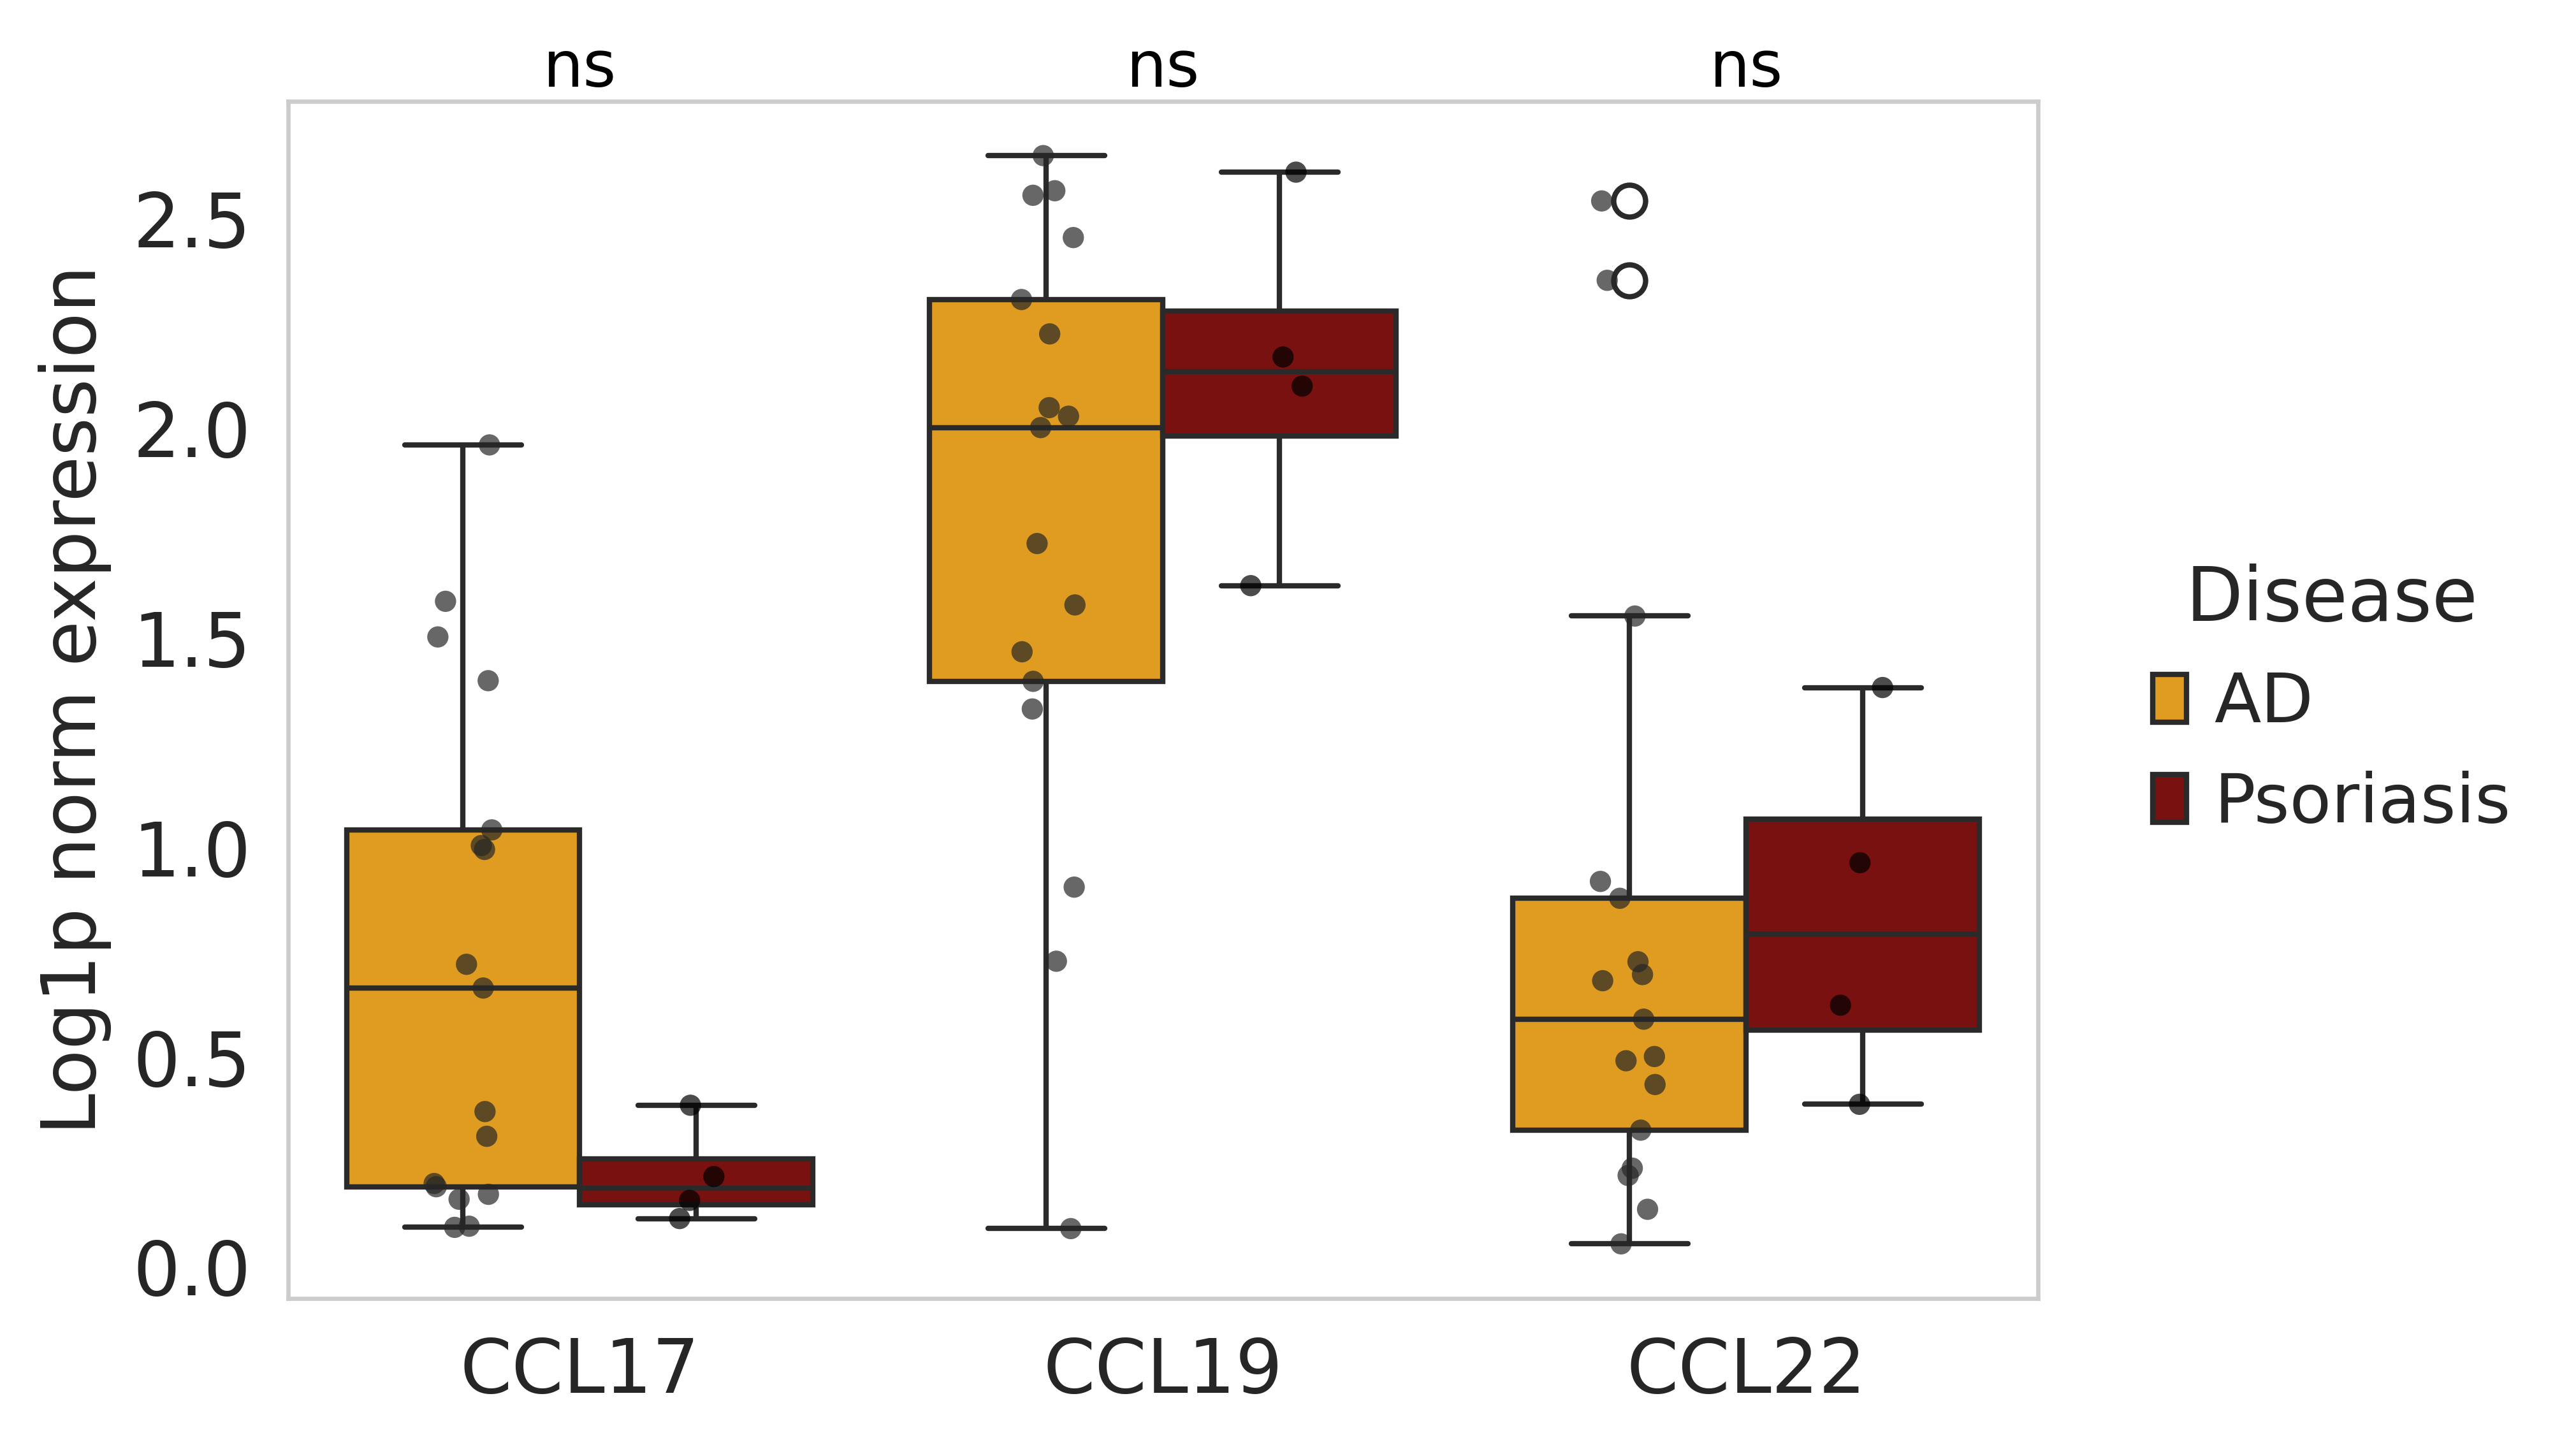

In [15]:
# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(7, 4), dpi=300)
sns.set_style("whitegrid", {'axes.grid': False})
custom_palette = {"AD": "orange", "Psoriasis": "darkred"}

ax = sns.boxplot(
    data=df_donors,
    x="gene",
    y="expression",
    hue="disease_overall",
    palette=custom_palette
)

sns.stripplot(
    data=df_donors,
    x="gene",
    y="expression",
    hue="disease_overall",
    dodge=True,
    size=4,
    color="k",
    alpha=0.7,
    ax=ax
)

# ----------------------------
# Legend outside plot (to the right)
# ----------------------------
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[:2],
    labels[:2],
    title="Disease",
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),   # move legend to the right
    loc="center left",
    borderaxespad=0
)

# ----------------------------
# Axis labels, title, annotations
# ----------------------------
ax.set_xlabel("")
ax.set_ylabel("Log1p norm expression")
ax.set_title("")

y_max = df_donors["expression"].max()
for i, row in results_df.iterrows():
    ax.text(i, y_max * 1.05, row["star"], ha="center", va="bottom", fontsize=12, color="black")

plt.tight_layout()
plt.savefig("supp/supp_ccl17_chemokines.pdf", dpi=300, bbox_inches="tight")
plt.show()